In [1]:
#|default_exp learner

In [116]:
#|export 
import torch,math
import matplotlib.pyplot as plt
import torch.nn.functional as F
from operator import attrgetter
import fastcore.all as fc
from collections.abc import Mapping
from copy import copy
from torch import optim
from fastprogress import progress_bar,master_bar
from miniai.conv import *

In [3]:
from datasets import load_dataset
import torchvision.transforms.functional as TF
from miniai.datasets import *
from torch import nn,tensor

### Learner

In [4]:
_x,_y = 'image','label'
name = 'fashion_mnist'
dr = load_dataset(name)

Found cached dataset fashion_mnist (/Users/arun/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
@inplace
def transformi(b):
    b[_x] = [torch.flatten(TF.to_tensor(e)) for e in b[_x]]

In [6]:
bs = 1024
tds = dr.with_transform(transformi)

In [7]:
dls = DataLoaders.from_dd(tds, batch_size=bs)
xb,yb = next(iter(dls.train))

In [28]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD):
        fc.store_attr()
    
    def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad():
            self.calc_stats()
    
    def calc_stats(self):
        acc = (self.preds.argmax(dim=1) == self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)
    
    def one_epoch(self, train):
        self.model.training = train
        self.dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(self.dl):
            self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.n_epochs = n_epochs
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr)
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad():
                self.one_epoch(False)

In [29]:
n,nh,nout = 28*28,50,10
model = nn.Sequential(nn.Linear(n, nh), nn.ReLU(), nn.Linear(nh, nout))
learner = Learner(model, dls, lr=0.2, loss_func=F.cross_entropy)

In [30]:
learner.fit(2)

0 True 1.143631640625 0.6196166666666667
0 False 1.09259609375 0.6317714285714285
1 True 0.9109576322115385 0.6837538461538462
1 False 0.8907945870535714 0.69035


### Basic Callbacks Listener

In [31]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [32]:
#|export
class Callback():
    order = 0

In [34]:
#|export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None:
            method(learn)

In [36]:
class CompletionCB(Callback):
    def before_fit(self, learn):
        self.count = 0
    
    def before_batch(self, learn):
        self.count += 1
    
    def after_fit(self, learn):
        print(f'Completed {self.count} batches')

In [40]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'before_batch')
run_cbs(cbs, 'before_batch')
run_cbs(cbs, 'after_fit')

Completed 2 batches


In [58]:
class Learner:
    def __init__(self, model, dls, lr, cbs, loss_func, opt_func=optim.SGD):
        fc.store_attr()
    
    def one_batch(self):
        self.xb,self.yb = self.batch
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
    
    def one_epoch(self, train):
        self.model.training = train
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.num,self.batch in enumerate(self.dl):
                    try:
                        self.callback('before_batch')
                        self.one_batch()
                        self.callback('after_batch')
                    except CancelBatchException:
                        pass
            self.callback('after_epoch')
        except CancelEpochException:
            pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException:
            pass
    
    def callback(self, method_nm):
        run_cbs(self.cbs, method_nm, self)

In [51]:
n,nh,nout = 28*28,50,10
def get_model():
    return nn.Sequential(nn.Linear(n,nh), nn.ReLU(), nn.Linear(nh, nout))

In [52]:
model = get_model()
cbs = [CompletionCB()]
learner = Learner(model, dls, loss_func=F.cross_entropy, lr=0.2, cbs=cbs)
learner.fit(1)

Completed 64 batches


In [60]:
#|export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn):
        raise CancelFitException()

In [59]:
model = get_model()
learner = Learner(model, dls, loss_func=F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learner.fit(1)

### Metrics

In [66]:
class Metric:
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.vals,self.ns = [],[]
    
    def add(self, inps, targs=None, n=1):
        self.last = self.calc(inps, targs)
        self.vals.append(self.last)
        self.ns.append(n)
    
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    
    def calc(self, inps, targs):
        return inps

In [67]:
class Accuracy(Metric):
    def calc(self, inps, targs):
        return (inps==targs).float().mean()

In [69]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.4500)

In [71]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.6176), 0.62)

### Some Callbacks

In [74]:
#|export
from torcheval.metrics import MulticlassAccuracy,Mean 

In [75]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.5000)

In [76]:
metric.reset()
metric.compute()

tensor(nan)

In [77]:
#|export
def to_cpu(x):
    if isinstance(x, Mapping):
        return {k: to_cpu(v) for k,v in x.items()}
    if isinstance(x, list):
        return [to_cpu(e) for e in x]
    if isinstance(x, tuple):
        return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

In [93]:
#|export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for e in ms:
            metrics[type(e).__name__] = e
        self.metrics = metrics
        self.all_metrics = copy(self.metrics)
        self.all_metrics['losss'] = self.loss = Mean()
    
    def before_epoch(self, learn):
        [e.reset() for e in self.all_metrics.values()]
    
    def before_fit(self, learn):
        learn.metrics = self
    
    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values():
            m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))
    
    def after_epoch(self, learn):
        log = {k:f'{m.compute():.3f}' for k,m in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)
    
    def _log(self, d):
        print(d)

In [94]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=def_device):
        fc.store_attr()
    
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'):
            learn.model.to(self.device)
    
    def before_batch(self, learn):
        learn.batch = to_device(learn.batch, device=self.device)

In [95]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, lr=0.2, loss_func=F.cross_entropy, cbs=[metrics, DeviceCB()])
learn.fit(1)

{'accuracy': '0.606', 'losss': '1.160', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.725', 'losss': '0.763', 'epoch': 0, 'train': 'eval'}


### Flexible Learner

In [96]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],\
                [fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],\
                [fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
                

In [122]:
#|export
def ProgressCB(Callback):
    def __init__(self, plot=False):
        self.plot = plot
    
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'):
            learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []
    
    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)
    
    def before_epoch(self, learn):
        learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses:
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],\
                 [fc.L.range(learn.epochs).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn):
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'):
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],\
                    [fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

In [166]:
mbar = master_bar(range(5))
for k in mbar:
    x = progress_bar(range(10000000), leave=False, parent=mbar)
    for i in x:
        pass

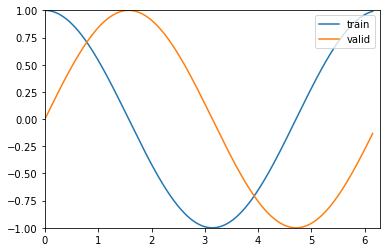

In [243]:
mb = master_bar(range(10))
for i in mb:
    for j in progress_bar(range(100), parent=mb):
        if j%20==0:
            k = i*100+j
            prcnt,bound = k/1000,2*np.pi
            x = np.arange(0, prcnt*bound, 0.01)
            y1,y2 = np.cos(x),np.sin(x)
            x_bounds = [0,bound]
            y_bounds = [-1, 1]
            mb.update_graph([[x,y1], [x,y2]], x_bounds,y_bounds)

In [ ]:
#|export    